In [1]:
from math import factorial
import matplotlib.pyplot as plt
import numpy as np

def offeredTraffic(calls_per_hour, hours_per_call): # A0
    return calls_per_hour*hours_per_call

def erlangB(n, A0):
    denom = 0
    for i in range(n+1):
        denom += (A0**i)/(factorial(i))
    E1 = ((A0**n)/factorial(n))/denom
    return E1

# def erlangC(n, A0):
#     denom = ((A0**n)/factorial(n))*(n/(n-A0))
#     for i in range(n):
#         denom += (A0**i)/factorial(i)
#     return ((A0**n)/factorial(n))*(n/(n-A0))/denom
def erlangC(n, A0):
    denomSum = 0
    for i in range(n):
        denomSum += (A0**i)/factorial(i)
    denom = A0**n + factorial(n)*(1-A0/n)*denomSum
    return (A0**n)/denom

def meanCallDelay(n, A0, meanCallDuration, probDelay):
    return probDelay*meanCallDuration/(n-A0)

def meanQueuedDelay(n, A0, meanCallDuration):
    return meanCallDuration/(n-A0)

    
# def erlangC_GOS():



In [2]:
def trafficSimulation(numChannels, numCalls, meanCallDuration, requeue=False):

    callDurations = np.random.exponential(scale=meanCallDuration, size=numCalls)
    callStarts = np.random.uniform(size=numCalls)
    
    callStarts.sort()
    
    # Calls = Numpy array of [[call0_start call0_end]; [call1_start call1_end];...
    calls = np.stack((callStarts, np.add(callStarts,callDurations)),axis=1)

    channelFreeTimes = np.zeros(numChannels)
    
    time = 0
    callsFailed = 0
    for i, call in enumerate(calls):
        time = call[0]
        channelFound = False
        for j in range(numChannels):
            if not(channelFound):
                if channelFreeTimes[j] < time:
                    # print("Time:", time)
                    # print("channelFreeTimes", channelFreeTimes)
                    # print("Channel {} free. Adding call time {}".format(j, call[1]))
                    channelFreeTimes[j] = call[1]
                    channelFound = True
        if channelFound == False:
            callsFailed += 1
            # print("Call {} ({}) failed.\n".format(i,call))
            # if requeue:


    return callsFailed/numCalls, callsFailed


In [3]:
meanCallDuration = 180/3600 # 3 mins in hrs
n = 11

minNumCalls = 1
maxNumCalls = 2000
numTests = 21
# simulationCallAmounts = np.concatenate((np.linspace(minNumCalls, maxNumCalls, numTests), np.linspace(2500, 6000, 8))).astype(np.int)
simulationCallAmounts = np.linspace(10, 300, 30).astype(np.int)
# simulationCallAmounts = np.linspace(200, 200, 1).astype(np.int)



repetitionsPerSimulation = 10
print(simulationCallAmounts)

[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200 210 220 230 240 250 260 270 280 290 300]


In [4]:
erlangBs = np.zeros(simulationCallAmounts.shape)
erlangCs = np.zeros(simulationCallAmounts.shape)
GOS_simulated = np.zeros(simulationCallAmounts.shape)
meanCallDelays = np.zeros(simulationCallAmounts.shape)
meanQueuedDelays = np.zeros(simulationCallAmounts.shape)

print("# Calls:\tErlang B:\tErlang C:\tSimulation:\tCall Delays\tQueued Delays")
for i, numCalls in enumerate(simulationCallAmounts):
    A0 = offeredTraffic(numCalls, meanCallDuration)
    erlangBs[i] = erlangB(n, A0)*100
    erlangCs[i] = erlangC(n, A0)*100
    meanCallDelays[i] = meanCallDelay(n, A0, meanCallDuration, erlangCs[i])
    meanQueuedDelays[i] = meanQueuedDelay(n, A0, meanCallDuration)
    
    totalFailRate, totalFailCount = 0, 0
    for j in range(repetitionsPerSimulation):
        failRate, failsCount = trafficSimulation(n, numCalls, meanCallDuration)
        totalFailRate += failRate
        totalFailCount += failsCount
    meanFailRate = totalFailRate/repetitionsPerSimulation
    meanFailCount = totalFailCount/repetitionsPerSimulation
    GOS_simulated[i] = meanFailRate*100
    # print("Call fail rate in {} simulations = {}% (mean of {} fails in {} calls)\n".format(repetitionsPerSimulation, GOS_simulated[i], meanFailCount, numCalls))


# for i, numCalls in enumerate(simulationCallAmounts):
    print("{}\t\t{:.2f}\t\t{:.2f}\t\t{:.2f}\t\t{:.2f}\t\t{:.2f}".format(numCalls,erlangBs[i], erlangCs[i], GOS_simulated[i], meanCallDelays[i], meanQueuedDelays[i]))

# Calls:	Erlang B:	Erlang C:	Simulation:	Call Delays	Queued Delays
10		0.00		0.00		0.00		0.00		0.00
20		0.00		0.00		0.00		0.00		0.01
30		0.00		0.00		0.00		0.00		0.01
40		0.00		0.00		0.00		0.00		0.01
50		0.00		0.01		0.00		0.00		0.01
60		0.02		0.03		0.00		0.00		0.01
70		0.07		0.11		0.00		0.00		0.01
80		0.19		0.30		0.12		0.00		0.01
90		0.43		0.72		0.22		0.01		0.01
100		0.83		1.51		0.00		0.01		0.01
110		1.44		2.84		0.55		0.03		0.01
120		2.30		4.92		1.42		0.05		0.01
130		3.41		7.95		2.31		0.09		0.01
140		4.77		12.11		3.50		0.15		0.01
150		6.36		17.58		4.80		0.25		0.01
160		8.13		24.50		7.38		0.41		0.02
170		10.05		32.96		10.59		0.66		0.02
180		12.08		43.05		11.17		1.08		0.03
190		14.18		54.79		10.68		1.83		0.03
200		16.32		68.21		16.30		3.41		0.05
210		18.47		83.29		16.29		8.33		0.10
220		20.61		100.00		19.86		inf		inf
230		22.71		118.30		23.22		-11.83		-0.10
240		24.78		138.12		25.79		-6.91		-0.05
250		26.79		159.42		24.32		-5.31		-0.03
260		28.74		182.12		26.50		-4.55		-0.03
270		30.62		2

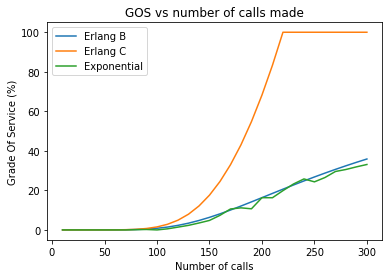

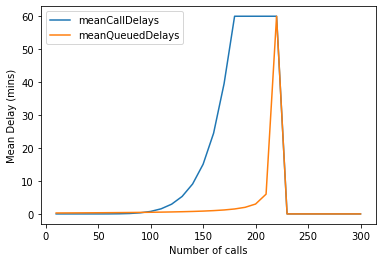

In [5]:
# print("Erlang B:\t\t\t Simulation:")
# for i, numCalls in enumerate(simulationCallAmounts):
#     print(GOS_erlang[i], "\t\t", GOS_simulated[i])

plt.plot(simulationCallAmounts, erlangBs, label='Erlang B')
plt.plot(simulationCallAmounts, np.clip(erlangCs,0,100), label='Erlang C')


plt.plot(simulationCallAmounts, GOS_simulated, label='Exponential')
plt.xlabel('Number of calls')
plt.ylabel('Grade Of Service (%)')
plt.title("GOS vs number of calls made")
plt.legend()
plt.show()

plt.plot(simulationCallAmounts, np.clip(meanCallDelays,0,1)*60, label='meanCallDelays')
plt.plot(simulationCallAmounts, np.clip(meanQueuedDelays,0,1)*60, label='meanQueuedDelays')
plt.xlabel('Number of calls')
plt.ylabel('Mean Delay (mins)')
plt.legend()
plt.show()